## VC_2_Lab_15_Fingerprint_Recognition.ipynb

Neste jupyter vamos fazer tentar criar uma Autoencoder para Fingerprint.

**[Autoencoders](https://en.wikipedia.org/wiki/Autoencoder#Image_Processing)** são redes neurais treinadas com o objetivo de copiar o seu input para o seu output. Esse interesse pode parecer meio estranho, mas na prática o objetivo é aprender representações (encodings) dos dados. Na área de processamento de imagens são utilizados para remover ruído de imagens (denoising) e super-resolução.

Este jupyter notebook deve ser executado no Google Colab (https://colab.research.google.com/) devendo o aluno carregar as imagens que estão compactadas no ZIP **Laboratório/face_recognition.zip** na pasta **VC_1/face_recognition/** dentro do seu Google Drive

### Visão Computacional 2

### Prof: José Humberto Cruvinel

Este jupyter notebook deve ser executado no Google Colab (https://colab.research.google.com/) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Entrando no diretório
%cd drive/My Drive/VC_1/fingerprint/

In [3]:
# Listando o conteúdo

%ls -la

In [4]:
# Imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from glob import glob
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
%matplotlib inline

In [5]:
%%time
# Carregando o conjunto de dados
data = glob('DB*/*')
images = []
def readImages(data):
    for i in range(len(data)):
        if i%100 == 0:
            print('Processados:',i)
        img = Image.open(data[i])
        img = img.resize((224,224))
        images.append(np.asarray(img))
    return images
images = readImages(data)

Processados: 0
Processados: 100
Processados: 200
Processados: 300
Wall time: 992 ms


In [6]:
# Convertendo as imagens para array
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
print("Dataset (images) shape: {}".format(images_arr.shape))

Dataset (images) shape: (320, 224, 224)


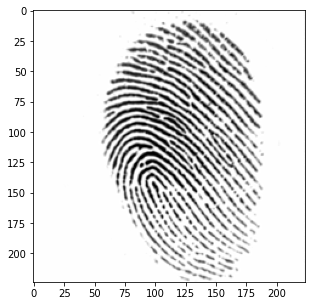

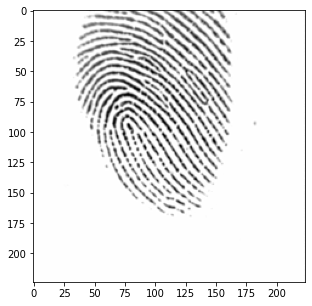

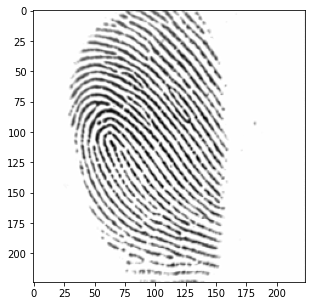

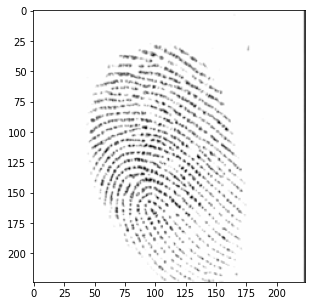

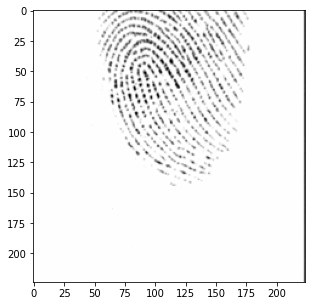

In [7]:
# Mostrando as primeiras 5 imagens
for i in range(5):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

In [8]:
images_arr = images_arr.reshape(-1, 224,224, 1)
print('Shape:',images_arr.shape)
print('Dtype:',images_arr.dtype)

Shape: (320, 224, 224, 1)
Dtype: float32


In [9]:
# Normalização, os valores devem ficar entre 0 e 1
np.max(images_arr)
images_arr = images_arr / np.max(images_arr)
print('Max:',np.max(images_arr))
print('Min:',np.min(images_arr))

Max: 1.0
Min: 0.0


In [10]:
# Como queremos criar um autoencoder, vamos passar o dataset duas vezes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_arr,images_arr,test_size=0.2,random_state=13)

In [11]:
BATCH_SIZE = 128
EPOCHS = 20
x, y = 224, 224
input_img = Input(shape = (x, y, 1))

In [12]:
# Criação da rede neural
def autoencoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)#decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [13]:
# Compilando o modelo
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics='accuracy')

In [14]:
# Treinamento
autoencoder_train = autoencoder.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test))

Epoch 1/20
2/2 [==============================] - 33s 16s/step - loss: 0.0685 - accuracy: 0.0121 - val_loss: 0.0796 - val_accuracy: 0.0031
Epoch 2/20
2/2 [==============================] - 33s 16s/step - loss: 0.0682 - accuracy: 0.0106 - val_loss: 0.0681 - val_accuracy: 0.0267
Epoch 3/20
2/2 [==============================] - 33s 16s/step - loss: 0.0596 - accuracy: 0.0189 - val_loss: 0.0728 - val_accuracy: 0.0267
Epoch 4/20
2/2 [==============================] - 33s 16s/step - loss: 0.0591 - accuracy: 0.0189 - val_loss: 0.0507 - val_accuracy: 0.0267
Epoch 5/20
2/2 [==============================] - 33s 16s/step - loss: 0.0572 - accuracy: 0.0188 - val_loss: 0.0518 - val_accuracy: 0.0267
Epoch 6/20
2/2 [==============================] - 34s 17s/step - loss: 0.0528 - accuracy: 0.0190 - val_loss: 0.0466 - val_accuracy: 0.0267
Epoch 7/20
2/2 [==============================] - 33s 16s/step - loss: 0.0392 - accuracy: 0.0183 - val_loss: 0.0349 - val_accuracy: 0.0265
Epoch 8/20
2/2 [===========

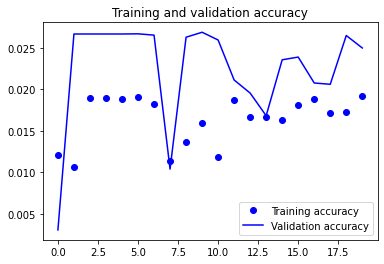

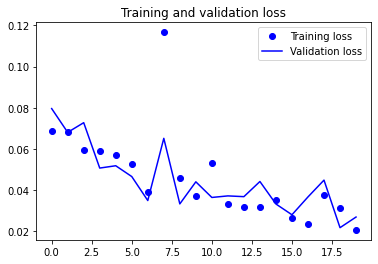

In [15]:
# Plotando os resultados
accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
# Prevendo os dados de teste
pred = autoencoder.predict(X_test)

Imagens de teste


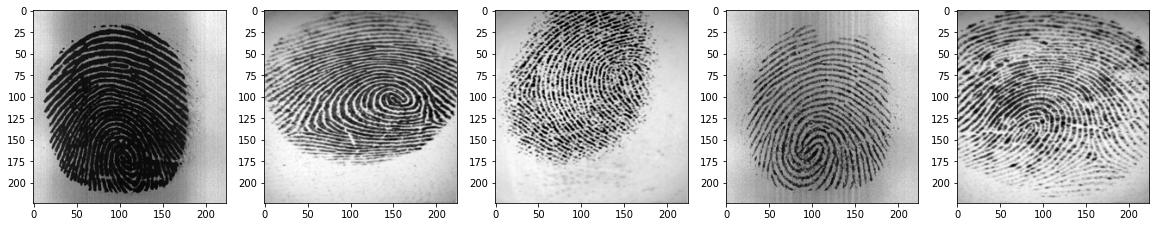

Reconstrução com o Autoencoder


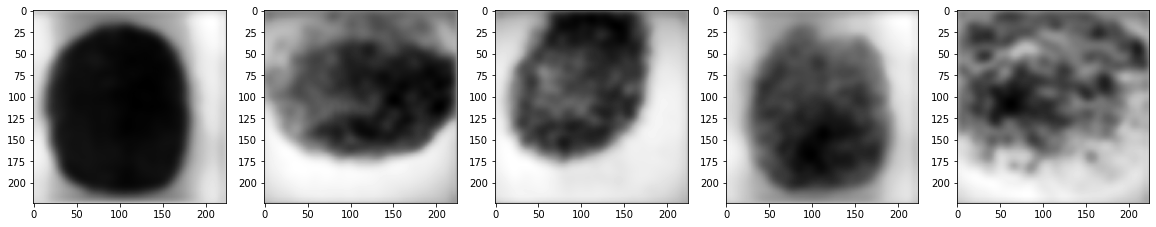

In [17]:
# Plotando algumas imagens
plt.figure(figsize=(20, 4))
print("Imagens de teste")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_test[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstrução com o Autoencoder")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

# Exercício 15.1

Veja que o nosso autoecoder ainda não está bom. 

Aumente a quantidade de passos de treinamento para tentar melhorar. Lembre de ativar o uso de GPU.

Após obter um bom autoencoder, escolha algumas imagens de teste, adicione um ruído nessa imagem e submeta ao autoencoder e veja o resultado, comparando a imagem resultante com a original sem ruído.

In [18]:
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_accuracy',
                          patience=3,verbose=1,factor=0.1)

In [19]:
BATCH_SIZE = 2

# Compilando o modelo
autoencoder.compile(loss='mean_squared_error',
                    optimizer = RMSprop(), metrics='accuracy')

# Treinamento
autoencoder_train = autoencoder.fit(
    X_train, y_train,     
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test),
    validation_steps=X_test.shape[0]//BATCH_SIZE,
    callbacks=[red_lr])

Epoch 1/20
128/128 [==============================] - 81s 632ms/step - loss: 0.0239 - accuracy: 0.0194 - val_loss: 0.0152 - val_accuracy: 0.0271
Epoch 2/20
128/128 [==============================] - 83s 652ms/step - loss: 0.0173 - accuracy: 0.0198 - val_loss: 0.0179 - val_accuracy: 0.0268
Epoch 3/20
128/128 [==============================] - 81s 631ms/step - loss: 0.0150 - accuracy: 0.0199 - val_loss: 0.0094 - val_accuracy: 0.0274
Epoch 4/20
128/128 [==============================] - 79s 616ms/step - loss: 0.0101 - accuracy: 0.0201 - val_loss: 0.0074 - val_accuracy: 0.0275
Epoch 5/20
128/128 [==============================] - 78s 610ms/step - loss: 0.0078 - accuracy: 0.0201 - val_loss: 0.0053 - val_accuracy: 0.0275
Epoch 6/20
128/128 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.0202
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
128/128 [==============================] - 78s 611ms/step - loss: 0.0064 - accuracy: 0.0202 - val_

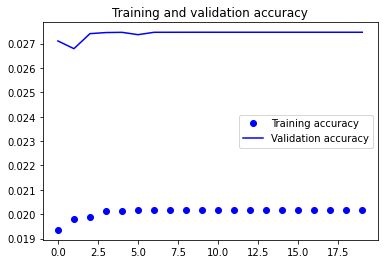

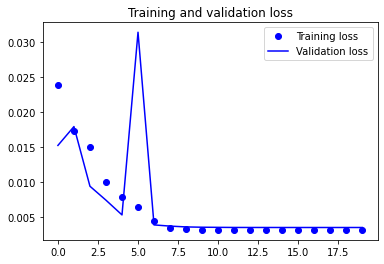

In [20]:
# Plotando os resultados
accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

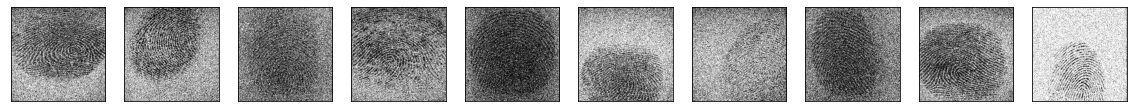

In [21]:
noise_factor = 0.3

X_train_noisy = X_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=X_train.shape) 

X_test_noisy = X_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
# Prevendo os dados de teste
pred_noisy = autoencoder.predict(X_test_noisy)

Imagens noisy teste


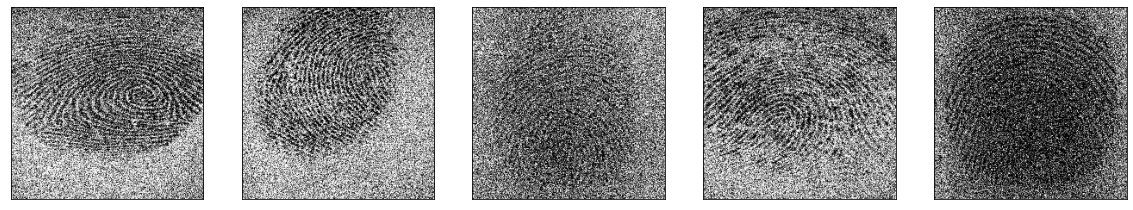

Reconstrução com o Autoencoder


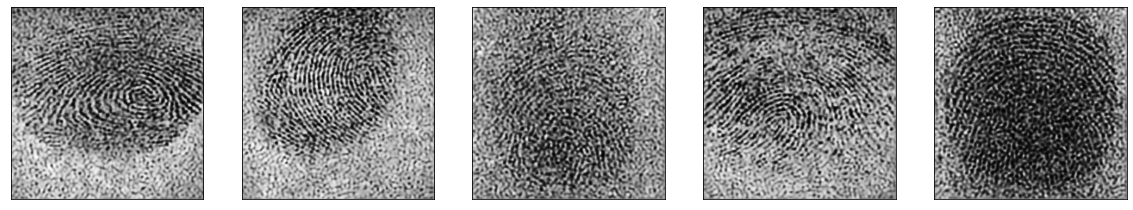

Imagens originais


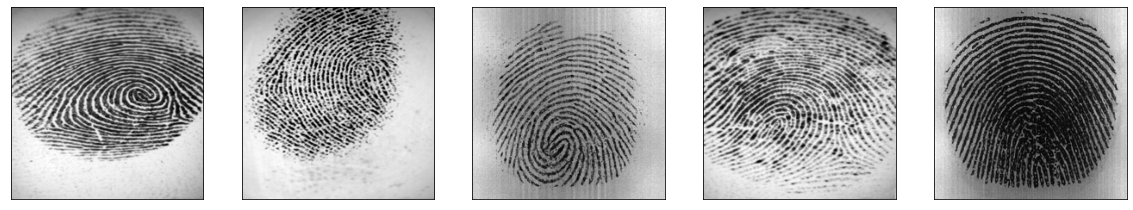

In [35]:
n = 5
    
print("Imagens noisy teste")  
plt.figure(figsize=(20, 5))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
        

plt.figure(figsize=(20, 5))
print("Reconstrução com o Autoencoder") 
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(pred_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
    

plt.figure(figsize=(20, 5))
print("Imagens originais") 
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

FIM